# Empowering Trustworthy Online Shopping with RealView App


## Business problem

## Overview

    In 2023, e-commerce sales experienced a remarkable 12% growth compared to 2022. The number of digital buyers worldwide is estimated to be 2.6 billion. Products with reviews have a 270% higher conversion rate, emphasizing the importance of credible feedback. 89% of customers read reviews before purchasing a product, with 75% trusting online reviews as much as personal recommendations.
    
    Did you know that around 40% of reviews online are fake? And out of those, 90% are just computer or AI generated, created to convince you about the product or service that you're browsing, instead of giving you information about other buyers.

    We developed "RealView", using Natural Language Processing techniques to empower users with credible and trrustworthy reviews, ensuring better shopping decisions.

    RealView is a revolutionary web browser extension and mobile app created to tackle this issue head-on.
    
    RealView allows users to input the product they're interested in and filters out computer or AI-generated reviews, keeping the ones written by humans

  ## Data Sources

    To power Realview, we're using a data source from OSF.IO, that consist of over 40.000 different reviews, both human made and computer generated. This balanced dataset allow us to develop a robust model for fake review detection.

## Data Sources

 To power RealView, we're using a data source from OSF.IO, that consist of over 40.000 different reviews, both human made and computer generated.

## Importing Packages

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import seaborn as sns

import xgboost

from PIL import Image

from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingClassifier, RandomForestClassifier,
                              StackingClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             auc, classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score, roc_curve, RocCurveDisplay)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                   train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from wordcloud import WordCloud

## Importing Data & EDA

In [2]:
#Importing dataset
df = pd.read_csv('fake reviews dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [3]:
df['label'].value_counts(normalize=True)

CG    0.5
OR    0.5
Name: label, dtype: float64

There we can see that we have a perfectly balanced dataset as far as our target.

In [4]:
df['category'].value_counts()

Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: category, dtype: int64

In [5]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
# Creating 'target' Column for Classification
df['target'] = np.where(df['label'] == 'CG', 1, 0)

### Distribution of categories by rating

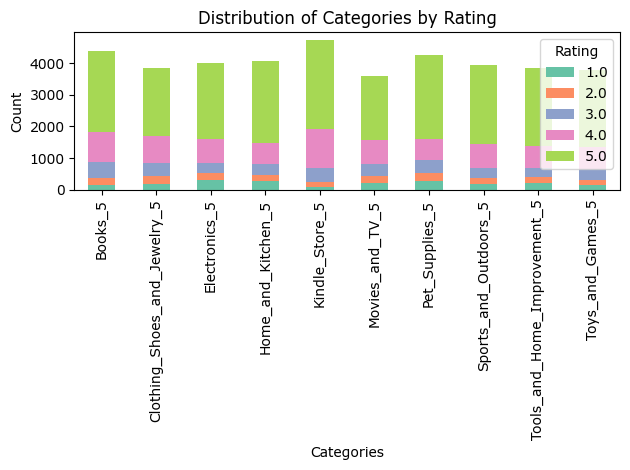

In [7]:
# Bar Chart for Distribution of Categories by Rating
sns.set_palette("Set2")

df_grouped = df.groupby(['category', 'rating']).size().unstack(fill_value=0)
ax = df_grouped.plot(kind='bar', stacked=True)

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Categories by Rating')
plt.xticks(rotation=90)
plt.legend(title='Rating')
plt.tight_layout()
plt.show()

Some categories, such as "Books" and "Kindle Store," have a more substantial proportion of highly positive reviews (5.0), while others like "Electronics" and "Pet Supplies" have a relatively higher number of reviews with lower ratings (1.0, 2.0, and 3.0).

<Figure size 1200x600 with 0 Axes>

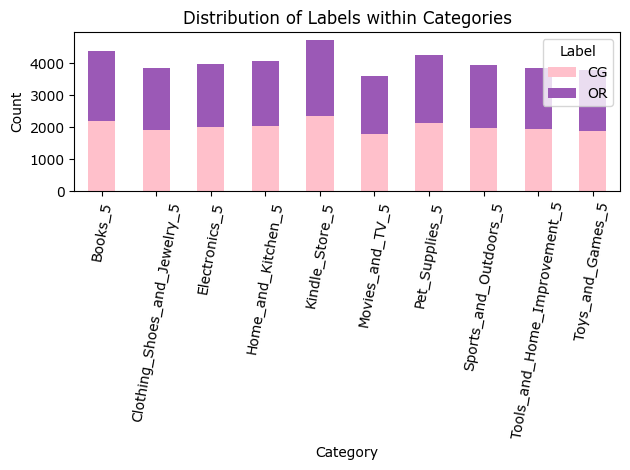

In [8]:
#Bar Chart for Distribution of Labels within Categories
plt.figure(figsize=(12, 6))
label_category_counts = df.groupby(['category', 'label']).size().unstack(fill_value=0)
label_category_counts.plot(kind='bar', stacked=True, color=['pink', '#9B59B6'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Labels within Categories')
plt.xticks(rotation=80)
plt.legend(title='Label')
plt.tight_layout()
#plt.show();

-  The table shows an equal distribution of the "CG" and "OR" labels within each category. 

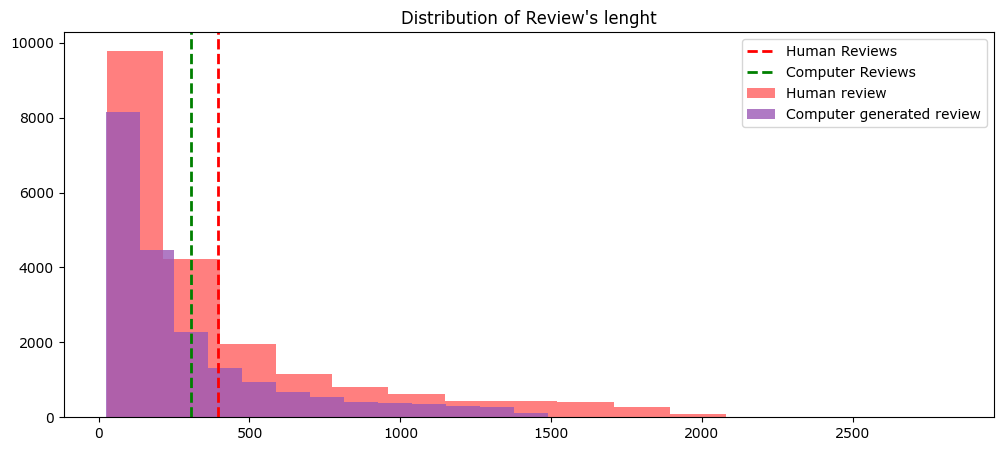

In [9]:
comp_gen = df[df['target'] == 1]
human_gen = df[df['target'] ==0]

fig, ax = plt.subplots(figsize=(12,5))
ax1 = plt.hist(human_gen['text_'].str.len(), bins=15, color='r', label='Human review', alpha=0.5)
ax2 = plt.hist(comp_gen['text_'].str.len(), bins=15, color= '#9B59B6', label='Computer generated review', alpha=0.8)
plt.axvline(human_gen['text_'].str.len().mean(), color='red', linestyle='dashed', linewidth=2, label='Human Reviews')
plt.axvline(comp_gen['text_'].str.len().mean(), color='green', linestyle='dashed', linewidth=2, label='Computer Reviews')
plt.title("Distribution of Review's lenght")
plt.legend();

We can see here that the human generated reviews tends to be larger than the computer generated.

Let's look now at the word count and evaluate their count

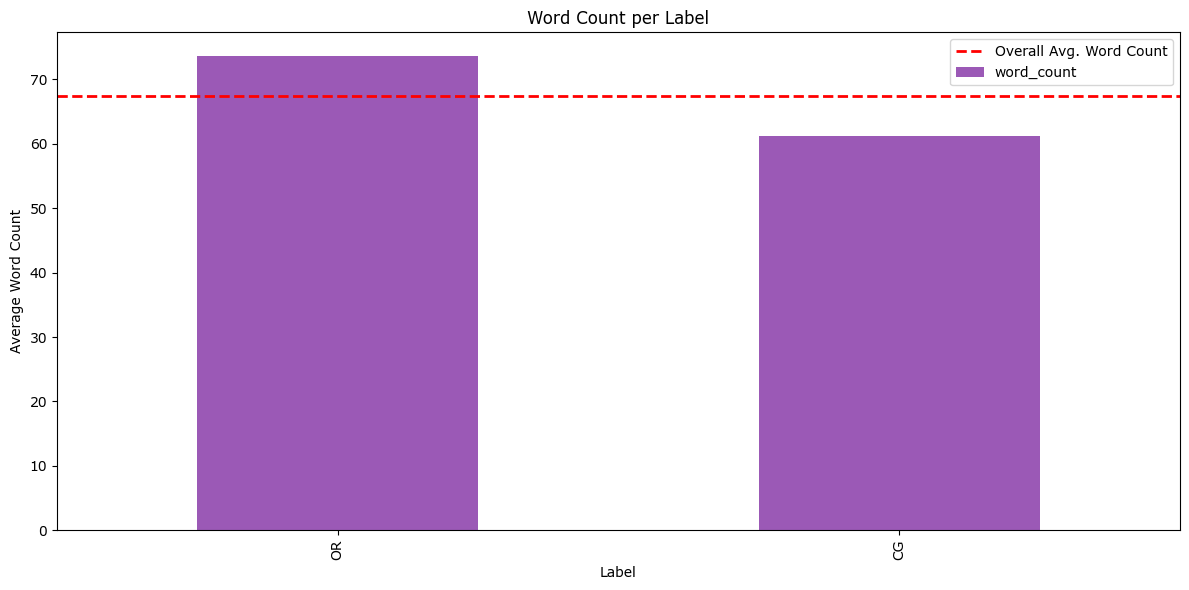

In [63]:
# Calculating Word Count for each review
df['word_count'] = df['text_'].apply(lambda x: len(x.split()))

# Calculating Average Word Count by Label
label_word_counts = df.groupby('label')['word_count'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
label_word_counts.plot(kind='bar', color='#9B59B6') 
plt.xlabel('Label')
plt.ylabel('Average Word Count')
plt.title('Word Count per Label')
plt.xticks(rotation=90)
plt.axhline(df['word_count'].mean(), color='red', linestyle='dashed', linewidth=2, label='Overall Avg. Word Count')
plt.legend()
plt.tight_layout()

plt.show()

On average, reviews with the "OR" label have a higher word count compared to reviews labeled as "CG." The mean word count for "OR" reviews is approximately 73.64 words, while the mean word count for "CG" reviews is lower at around 61.29 words.

In [11]:
# Examining the count of reviews by rating and label
label_rating_counts = df.groupby(['label', 'rating']).size().unstack(fill_value=0)
label_rating_counts

rating,1.0,2.0,3.0,4.0,5.0
label,,,,,
CG,1063,962,1952,3920,12319
OR,1092,1005,1834,4045,12240


<Figure size 1200x600 with 0 Axes>

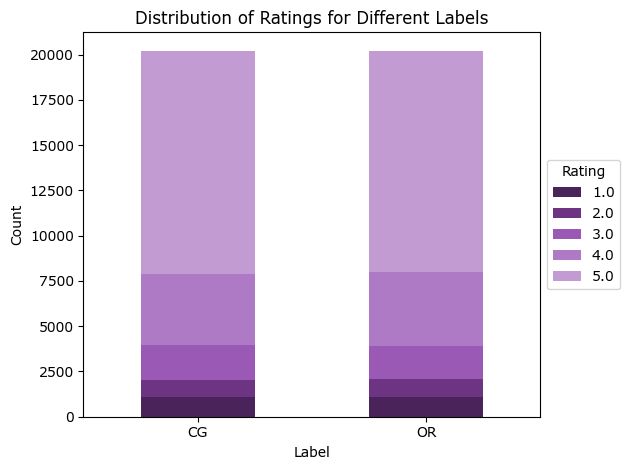

In [12]:
# Distribution of Ratings for Different Labels
custom_purple_palette = ['#C39BD3', '#AF7AC5', '#9B59B6', '#6C3483', '#4A235A']

plt.figure(figsize=(12, 6))
label_rating_counts.plot(kind='bar', stacked=True, color=custom_purple_palette[::-1])  # Reverse the color palette

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Ratings for Different Labels')
plt.xticks(rotation=0)
plt.legend(title='Rating', labels=label_rating_counts.columns, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show();

- Both "CG" and "OR" labels exhibit a relatively balanced distribution of ratings. While both labels have a similar distribution of ratings, the "CG" label appears to have slightly fewer reviews with 4.0 and 5.0 ratings compared to the "OR" label. Across both labels, positive ratings (4.0 and 5.0) significantly outnumber negative ratings (1.0 and 2.0).

In [13]:
label_category_counts = df.groupby(['label', 'category']).size().unstack(fill_value=0)
label_category_counts

category,Books_5,Clothing_Shoes_and_Jewelry_5,Electronics_5,Home_and_Kitchen_5,Kindle_Store_5,Movies_and_TV_5,Pet_Supplies_5,Sports_and_Outdoors_5,Tools_and_Home_Improvement_5,Toys_and_Games_5
label,,,,,,,,,,
CG,2185,1924,1994,2028,2365,1794,2127,1973,1929,1897
OR,2185,1924,1994,2028,2365,1794,2127,1973,1929,1897


### Word Cloud for Label column

In [14]:
# Filtering Data for 'CG' and 'OR' Labels
df_cg = df[df['label'] == 'CG']  
df_or = df[df['label'] == 'OR']

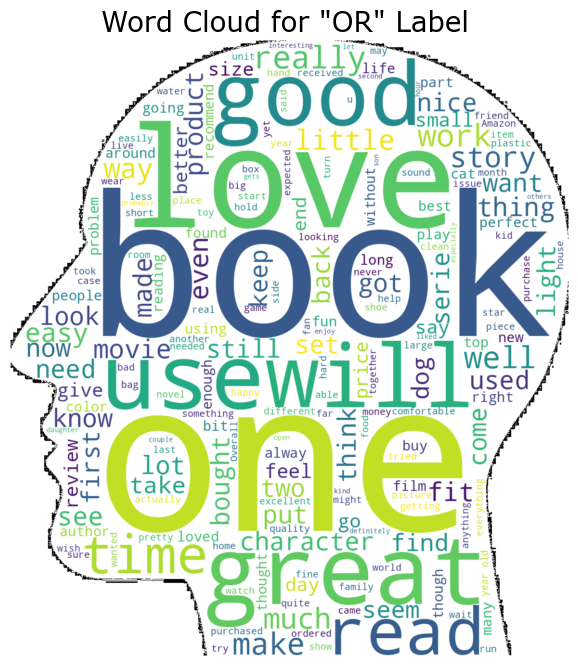

In [15]:
# Word Cloud for 'OR' Label Using a Custom Mask
face_mask = np.array(Image.open('face_picture.jpeg'))
text_corpus = " ".join(df_or['text_'])

wordcloud = WordCloud(
    width=600,
    height=600,
    background_color='white',
    mask=face_mask,
    contour_color='black',  
    contour_width=1,
).generate(text_corpus)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "OR" Label ', fontsize=20)
plt.show()

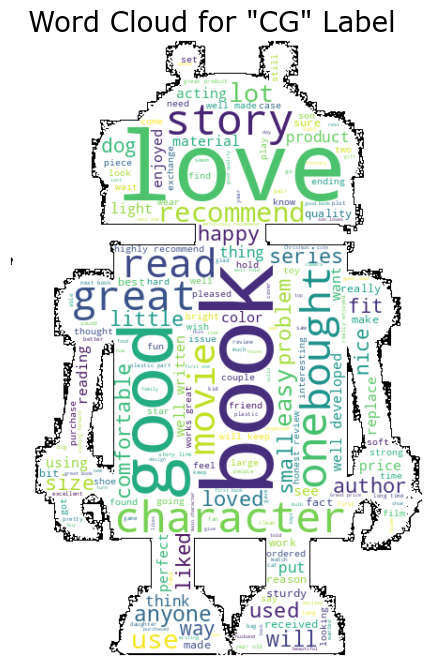

In [16]:
# Word Cloud for 'CG' Label Using a Custom Mask
robot_mask = np.array(Image.open('SIlhouette.png'))
text_corpus_2 = " ".join(df_cg['text_'])

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    mask=robot_mask,
    contour_color='black',  
    contour_width=1,
).generate(text_corpus_2)


plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "CG" Label ', fontsize=20)
plt.show()

# Data Preprocessing

## Text Preprocessing: Tokenization & Lemmantization

One of the most important things to do when preprocessing language data is to tokenize them, and apply either lemmantizing or stemming.

We decided to go for stemming since is richer, and in order to avoid data leakage we created functions for all the preprocessing to apply in the train and test data once we split it

In [17]:
# Defining Tokenizer function

def tokenizer(x):
    
    corpus = [word_tokenize(doc) for doc in x]

# Getting common stop words in english that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')
    corpus_no_stopwords = []
    for words in corpus:
        docs = [x.lower() for x in words if ((x.isalpha()) & (x not in stop_words))]
        corpus_no_stopwords.append(docs)
    return corpus_no_stopwords

# Defining Lemmatizer function, we can decide with the parameter "as_string" if we want to have the result tokenized or join

def lemmatizer(corpus, as_string=True):
    lem = WordNetLemmatizer()
# Defining an inner function 'pos_tagger'    
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
    lemmatized_corpus = []
    for sentence in corpus:
        pos_tags = pos_tag(sentence)
        lemmatized_sentence = []
        for word, tag in pos_tags:
            pos = pos_tagger(tag)
            if pos is not None:
                lemmatized_word = lem.lemmatize(word, pos)
            else:
                lemmatized_word = lem.lemmatize(word)
            lemmatized_sentence.append(lemmatized_word)
        lemmatized_corpus.append(lemmatized_sentence)
    if as_string:
        lemmatized_corpus  = [' '.join(x) for x in lemmatized_corpus]
    return lemmatized_corpus
    
# After processing all words in the sentence, the lemmatized_sentence is added to the lemmatized_corpus
        

### Splitting Data into Training and Testing Sets

In [18]:
# Dividing train and test data, setting 30% for test

X_train, X_test, y_train,y_test = train_test_split(df['text_'],df['target'], test_size=0.3,random_state=42)

# Preprocessing both Train and Test Data
X_train_preprocessed = lemmatizer(tokenizer(X_train))
X_test_preprocessed = lemmatizer(tokenizer(X_test))

## Baseline model testing two different vectorizers

The next step in our preprocessing is to vectorize the sentences, to do that we need to choose either Count Vectorizer and TF-IDF Vectorizer, to decide we'll run a Logistic Regression and a Random Forest with the data preprocessed in both ways to compare.

To account for the overfitting of Random Forest without any type of hyperparameter tuning, we'll apply cross validationt to these models.

Since we have balanced data, and there's not significant difference between having false negatives and false positives, we decided to use accuracy as a metric

### Random Forest and Logistic Regression with the Count Vectorizer

In [19]:
# Train and Evaluate Random Forest Model with CountVectorizer

steps = [('countvec',CountVectorizer(min_df = 0.05, max_df = 0.95)),('rfc',RandomForestClassifier(n_estimators=200,random_state=42))]
pipe_cv_rf = Pipeline(steps)
pipe_cv_rf.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Random Forest Model with CountVectorizer
crossval_rf_cv = np.mean(cross_val_score(pipe_cv_rf, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_rf_cv

0.7627021346850904

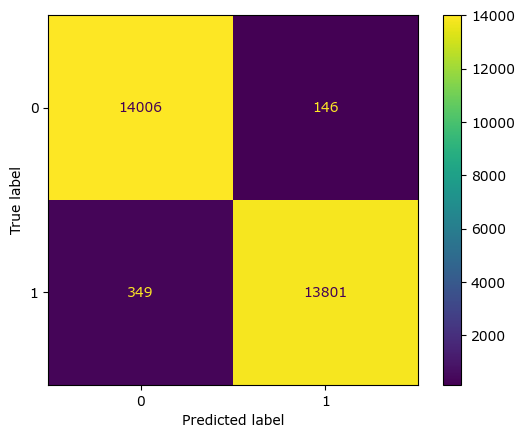

In [20]:
# Plotting the confusion matrix for Random Forest
ConfusionMatrixDisplay(confusion_matrix(y_train,pipe_cv_rf.predict(X_train_preprocessed))).plot();

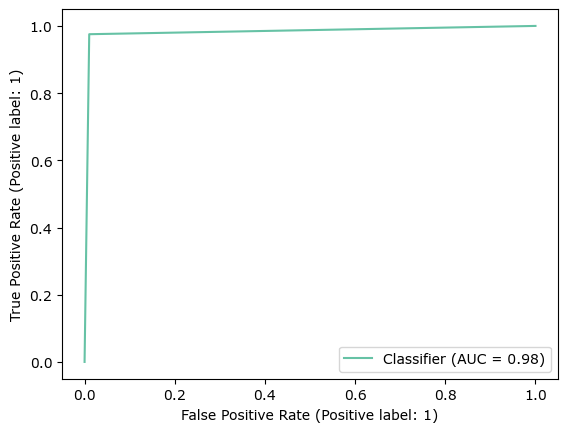

In [21]:
# Plotting ROC curve for Random Forest
RocCurveDisplay.from_predictions(y_train, pipe_cv_rf.predict(X_train_preprocessed))

In [22]:
# Train and Evaluate Logistic Regression Model with CountVectorizer
steps[1] = ('logreg',LogisticRegression(random_state=42))
pipe_cv_lr = Pipeline(steps)
pipe_cv_lr.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Logistic Regression Model with CountVectorizer
crossval_lr_cv = np.mean(cross_val_score(pipe_cv_lr, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_lr_cv

0.7266269054338063

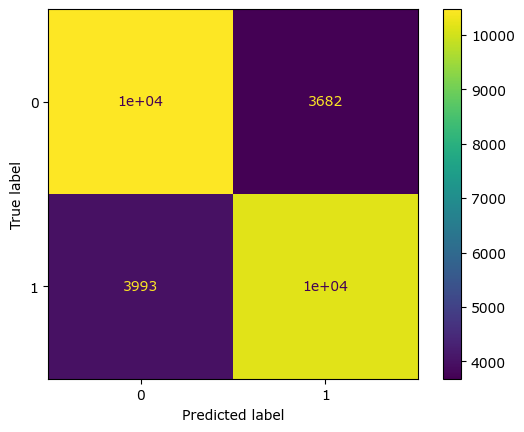

In [23]:
# Plotting the confusion matrix for Logistic Regression
ConfusionMatrixDisplay(confusion_matrix(y_train,pipe_cv_lr.predict(X_train_preprocessed))).plot();

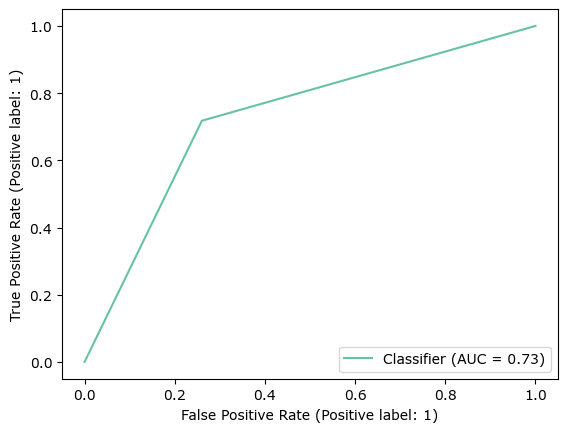

In [24]:
# Plotting ROC curve for Logistic Regression
RocCurveDisplay.from_predictions(y_train, pipe_cv_lr.predict(X_train_preprocessed))

### Random Forest and Logistic Regression with the TF-IDF Vectorizer

In [25]:
# Train and Evaluate Random Forest Model with TfidfVectorizer
steps = [('tfidfvec',TfidfVectorizer(min_df = 0.05, max_df = 0.95)),('rfc',RandomForestClassifier(n_estimators=200,random_state=42))]
pipe_idf_rf = Pipeline(steps)
pipe_idf_rf.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Random Forest Model with TfidfVectorizer
crossval_rf_idf = np.mean(cross_val_score(pipe_idf_rf, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_rf_idf

0.7631969029932032

In [26]:
# Train and Evaluate Logistic Regression Model with TfidfVectorizer
steps[1] = ('logreg',LogisticRegression(random_state=42))
pipe_idf_lr = Pipeline(steps)
pipe_idf_lr.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Logistic Regression Model with TfidfVectorizer
crossval_lr_idf = np.mean(cross_val_score(pipe_idf_lr, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_lr_idf

0.7267683043675561

After evaluating the models with both types of vectorizers, we decided to choose the Count Vectorizer for further analysis

In [27]:
# Instantiating the Count Vectorizer and applying it to both train and test data

vectorizer = CountVectorizer(min_df=0.05,max_df=0.95)

X_train_vec = vectorizer.fit_transform(X_train_preprocessed)
X_test_vec = vectorizer.transform(X_test_preprocessed)

## Hyper Parameter Tuning

### Parameter Grids

Defining parameter grids for all of the models we will try

In [28]:
# Defining Hyperparameter Grids for Random Forest and Logistic Regression Models
param_grid_random_forest = {'n_estimators':[100,150,200],
                       'max_depth':[2,3,4,5],
                       'min_samples_leaf':[1,2,3]
                      }

param_grid_logistic_regression = {'penalty':['l1', 'l2', 'elasticnet', None],
                 'C':[0.001,0.01,0.1,1,10,100],
                 'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
                }

param_grid_ada = {'n_estimators':[50,100,150,200],
                  'learning_rate':[0.01,0.1,0.2,0.5,1]
                 }

param_grid_gradient = {'n_estimators':[50,100,150,200],
                       'learning_rate':[0.01,0.1,0.2,0.5,1],
                       'max_depth':[1,2,3,4]
                      }

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2]
}

### Hyperparameter Tuning with GridSearchCV

In [29]:
# Applying GridSearchCV on different models to get the best set of hyper-parameters for each one

gs_rf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=200,random_state=42), param_grid=param_grid_random_forest,scoring='accuracy',cv=5,error_score=0)
gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=42,max_iter=10000), param_grid=param_grid_logistic_regression,scoring='accuracy',cv=5,error_score=0)
gs_ada = GridSearchCV(estimator=AdaBoostClassifier(random_state=42), param_grid=param_grid_ada,scoring='accuracy',cv=5,error_score=0)
gs_gradient = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid_gradient,scoring='accuracy',cv=5,error_score=0)
gs_xgb = GridSearchCV(estimator=xgboost.XGBClassifier(random_state=42, objective='binary:logistic'), param_grid=param_grid_xgb,scoring='accuracy',cv=5,error_score=0)

In [30]:
# Fitting each GridSearch object with out training data

gs_rf.fit(X_train_vec,y_train)
gs_lr.fit(X_train_vec,y_train)
gs_ada.fit(X_train_vec,y_train)
gs_gradient.fit(X_train_vec,y_train)
gs_xgb.fit(X_train_vec,y_train)

KeyboardInterrupt: 

In [ ]:
# Best Hyperparameters for each Model
best_random_forest = gs_rf.best_estimator_
best_logistic_regression = gs_lr.best_estimator_
best_ada_boost = gs_ada.best_estimator_
best_gradient = gs_gradient.best_estimator_
best_xgboost = gs_xgb.best_estimator_

In [ ]:
# Score for the Random Forest Model with best hyper parameters
gs_rf.best_score_

In [ ]:
# Score for the Logistic Regression Model with best hyper parameters
gs_lr.best_score_

In [ ]:
# Score for the Ada Booster Model with best hyper parameters
gs_ada.best_score_

In [ ]:
# Score for the Gradient Booster Model with best hyper parameters
gs_gradient.best_score_

In [ ]:
# Score for the XGBoost Model with best hyper parameters
gs_xgb.best_score_

Based on the scores, XGBoost has the highest one, making it the best-performing model

## Best XGBoost Estimator and Bagging

In [ ]:
# Bagging with XGBoost Classifier
bagging = BaggingClassifier(estimator=best_xgboost, n_estimators=100)

crossval_xgb_bagging = np.mean(cross_val_score(bagging, X_train_vec, y_train, scoring='accuracy', cv=5))
crossval_xgb_bagging

### Averaging the Models

In [ ]:
avg = VotingClassifier(estimators=[
    ('lr', best_logistic_regression),
    ('rf', best_random_forest),
    ('xgb', best_xgboost),
    ('ada', best_ada_boost),
    ('gradient', best_gradient)])
avg.fit(X_train_vec, y_train)

In [ ]:
# Calculating Mean Cross-Validation Score for the Voting Classifier Model
cross_val_voting = np.mean(cross_val_score(avg,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_voting

### Weighted Averaging with the VotingClassifier

In [ ]:
# Calculating Mean Cross-Validation Score for the Weighted Voting Classifier Model
w_avg = VotingClassifier(estimators=[
    ('lr', best_logistic_regression),
    ('rf', best_random_forest),
    ('xgb', best_xgboost),
    ('ada', best_ada_boost),
    ('gradient', best_gradient)],
                        weights=[0.05, 0.05, 0.5, 0.2, 0.2])
w_avg.fit(X_train_vec, y_train)

cross_val_weighted_voting = np.mean(cross_val_score(w_avg,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_weighted_voting

- We assigned a weight of 0 to 'lr' and 'rf' because their scores are too low compared to the other estimators


## Stacking

In [ ]:
# Stacking Classifier
estimators = [
    ('bag',bagging),
    ('xgb', best_xgboost),
    ('gradient', best_gradient),
    ('ada', best_ada_boost)
    
]
# Stacking Classifier Cross-Validation
sr = StackingClassifier(estimators).fit(X_train_vec,y_train)
cross_val_stacking = np.mean(cross_val_score(sr,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_stacking

## Shallow Neural Network

In [31]:
# Training a Neural Network for Binary Classification
baseline_nn = Sequential()
baseline_nn.add(Dense(50, input_dim=91, activation='relu'))
baseline_nn.add(Dense(units=1, activation='sigmoid'))
baseline_nn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
history = baseline_nn.fit(X_train_vec.toarray(), y_train, epochs = 100, batch_size = 32, validation_split = 0.2)

Epoch 1/100
708/708 [==============================] - 1s 1ms/step - loss: 0.5516 - accuracy: 0.7041 - val_loss: 0.5132 - val_accuracy: 0.7402
Epoch 2/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4981 - accuracy: 0.7479 - val_loss: 0.4939 - val_accuracy: 0.7522
Epoch 3/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4757 - accuracy: 0.7613 - val_loss: 0.4810 - val_accuracy: 0.7594
Epoch 4/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4575 - accuracy: 0.7717 - val_loss: 0.4696 - val_accuracy: 0.7642
Epoch 5/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4431 - accuracy: 0.7812 - val_loss: 0.4666 - val_accuracy: 0.7682
Epoch 6/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4316 - accuracy: 0.7878 - val_loss: 0.4599 - val_accuracy: 0.7698
Epoch 7/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4216 - accuracy: 0.7944 - val_loss: 0.4637 - val_accuracy: 0.7686

With an accuracy of 0.877 and a validation accuracy of 0.745 we can safely say that is overfitting, now, let's try to improve our model

In [32]:
# Displaying the Summary of the Baseline Neural Network Model
baseline_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                4600      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4,651
Trainable params: 4,651
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Generating Predicted Probabilities (y_hat_proba) Using the Baseline Neural Network Model
y_hat_proba = baseline_nn.predict(X_train_vec.toarray())

885/885 [==============================] - 1s 595us/step


In [34]:
# Calculating Accuracy Score for Training Data Using the Baseline Neural Network Model
y_hat_train = (y_hat_proba > 0.5).astype('int')
accuracy_score(y_train, y_hat_train)

0.8609638894777755

In [35]:
# Calculating Training Accuracy for the Baseline Neural Network Model
_, train_accuracy = baseline_nn.evaluate(X_train_vec.toarray(), y_train, verbose=1)
print(train_accuracy)

885/885 [==============================] - 1s 735us/step - loss: 0.3362 - accuracy: 0.8610
0.8609638810157776


## Deep Neural Network

In [65]:
# Training a Complex Neural Network for Binary Classification with Regularization
reg = l2(6e-10) 
model_complex = Sequential()
model_complex.add(Dense(110, input_dim=91, activation='relu',kernel_regularizer=reg))
model_complex.add(Dropout(0.5))
model_complex.add(Dense(80, activation='softmax',kernel_regularizer=reg))
model_complex.add(Dropout(0.5))
model_complex.add(Dense(50, activation='tanh',kernel_regularizer=reg))
model_complex.add(Dropout(0.2))
model_complex.add(Dense(70, activation='relu',kernel_regularizer=reg))
model_complex.add(Dense(70, activation='tanh',kernel_regularizer=reg))
model_complex.add(Dense(units=1, activation='sigmoid'))
model_complex.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
trainCallback = EarlyStopping(monitor='val_accuracy', patience = 7,restore_best_weights=True)
history = model_complex.fit(X_train_vec.toarray(), y_train, epochs = 200, batch_size = 40, validation_split = 0.2,callbacks=[trainCallback])

Epoch 1/200
567/567 [==============================] - 2s 2ms/step - loss: 0.6012 - accuracy: 0.6592 - val_loss: 0.5256 - val_accuracy: 0.7310
Epoch 2/200
567/567 [==============================] - 1s 2ms/step - loss: 0.5415 - accuracy: 0.7225 - val_loss: 0.5055 - val_accuracy: 0.7465
Epoch 3/200
567/567 [==============================] - 1s 2ms/step - loss: 0.5173 - accuracy: 0.7370 - val_loss: 0.4894 - val_accuracy: 0.7545
Epoch 4/200
567/567 [==============================] - 1s 2ms/step - loss: 0.5034 - accuracy: 0.7459 - val_loss: 0.4839 - val_accuracy: 0.7500
Epoch 5/200
567/567 [==============================] - 1s 2ms/step - loss: 0.4895 - accuracy: 0.7548 - val_loss: 0.4797 - val_accuracy: 0.7647
Epoch 6/200
567/567 [==============================] - 1s 2ms/step - loss: 0.4831 - accuracy: 0.7564 - val_loss: 0.4723 - val_accuracy: 0.7666
Epoch 7/200
567/567 [==============================] - 1s 2ms/step - loss: 0.4720 - accuracy: 0.7659 - val_loss: 0.4698 - val_accuracy: 0.7628

In [66]:
model_complex.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 110)               10120     
                                                                 
 dropout_6 (Dropout)         (None, 110)               0         
                                                                 
 dense_15 (Dense)            (None, 80)                8880      
                                                                 
 dropout_7 (Dropout)         (None, 80)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                4050      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 70)               

In [67]:
# Predicting the Training Set Labels for the Complex Neural Network Model
y_hat_proba = model_complex.predict(X_train_vec.toarray())
y_hat_train = (y_hat_proba > 0.5).astype('int')

885/885 [==============================] - 1s 591us/step


In [68]:
# Evaluating the Training Accuracy for the Complex Neural Network Model
_, train_accuracy = model_complex.evaluate(X_train_vec.toarray(), y_train, verbose=1)
print(train_accuracy)

885/885 [==============================] - 1s 676us/step - loss: 0.3670 - accuracy: 0.8306
0.8306480050086975


## Results

Below wew have the result of our best performing Neural Network, let's look at it's structure and analyze it's performance on the test data.

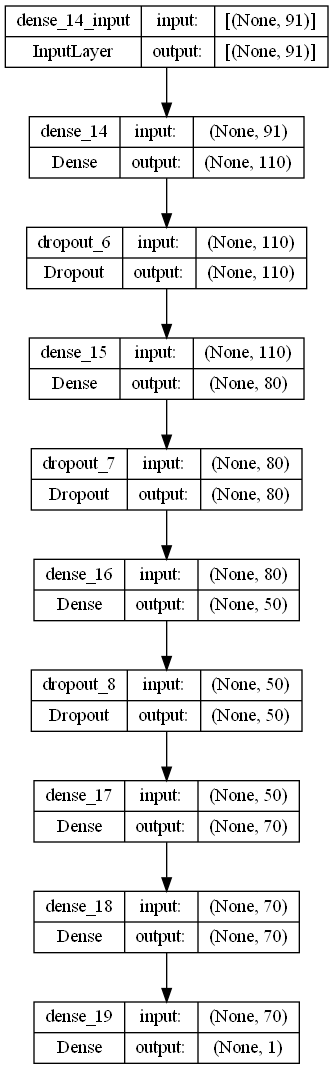

In [69]:
# Displaying the Architecture of the Complex Neural Network Model
plot_model(model_complex,to_file='model.png', show_shapes=True, show_layer_names=True)

In [70]:
# Evaluating the Test Accuracy for the Complex Neural Network Model
_, test_accuracy = model_complex.evaluate(X_test_vec.toarray(), y_test, verbose=1)
print(test_accuracy)

380/380 [==============================] - 0s 697us/step - loss: 0.4581 - accuracy: 0.7770
0.7769991755485535


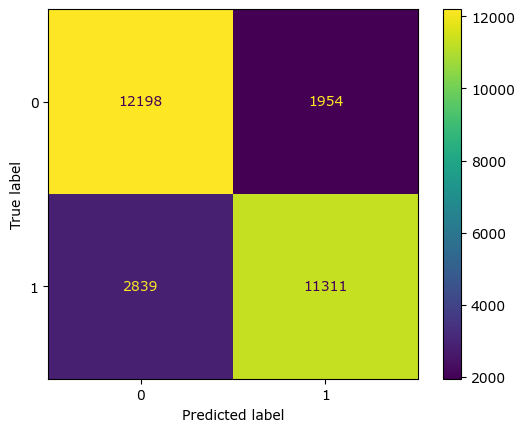

In [71]:
# Plotting the confusion matrix for Best Model
ConfusionMatrixDisplay(confusion_matrix(y_train,y_hat_train)).plot();

We can see it has a good performance with less than 5000 false predictions, in a dataset this size, is not too significant.

In [72]:
# Predicting the Test Set Labels for the Complex Neural Network Model
y_hat_proba_test = model_complex.predict(X_test_vec.toarray())
y_hat_test = (y_hat_proba_test > 0.5).astype('int')

380/380 [==============================] - 0s 598us/step


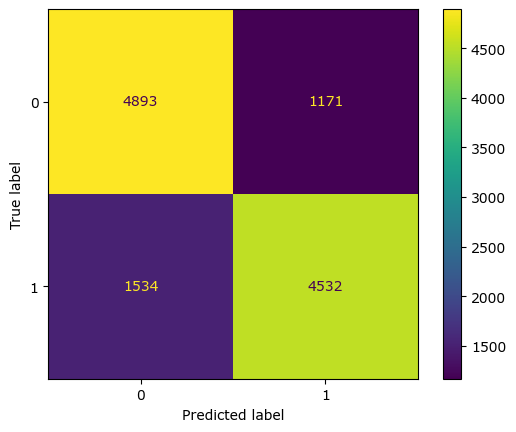

In [73]:
# Plotting the confusion matrix for Best Model(test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_hat_test)).plot();

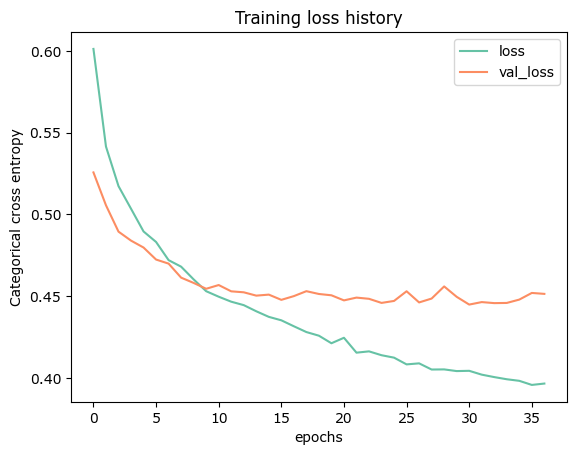

In [74]:
# Plotting Training Loss History
model_complex_df = pd.DataFrame(data=history.history)
model_complex_df.index.name = 'epochs'

col_list = ['loss', 'val_loss']
model_complex_df[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

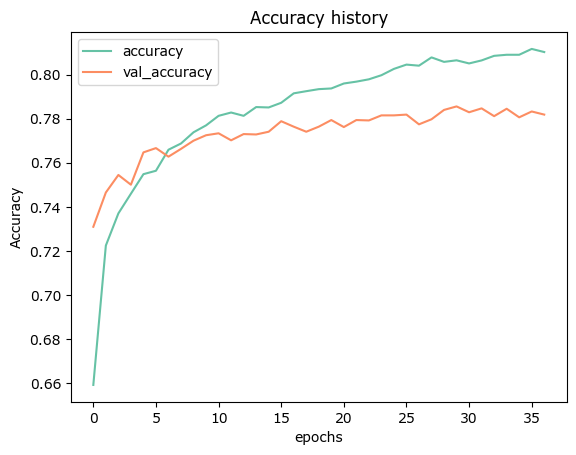

In [75]:
# Plotting Accuracy History
col_list = ['accuracy', 'val_accuracy']
model_complex_df[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.show()

## Recommendations

- Use the feedback collected from users to continuously improve your product
- Ensure that your system is scalable to handle a growing number of users and a vast amount of data
- Collaborate with e-commerce platforms and retailers to integrate your RealView technology directly into their websites

## Next Steps

- Develop real-time review detection capabilities
- Create a Feedback Mechanism,  that enables users to report suspicious reviews 
- Extend the reach of RealView to international markets and multiple languages